In [3]:
#!pip install shap xgboost

In [4]:
# Imports
# standard libraries
import pandas as pd 
import numpy as np
import pickle

# model
from xgboost import XGBClassifier

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV

# explainability
import shap

import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    confusion_matrix
) 

# src imports
import sys
sys.path.append('../src')

# from src.data.clean_data import TrainingPipeline
# from models.evaluate_model import calibrate_predictions, get_model_metrics, plot_model_evaluation
# from utils.shap_utils import save_shap_summary_plot

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

d:\mlops_project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def load_data(file_path):
    """Load data from a pickle file."""
    with open(file_path, 'rb') as file:
        return pickle.load(file)

In [6]:
X_train = load_data('../data/processed/X_train.pkl')
y_train = load_data('../data/processed/y_train.pkl')

X_test = load_data('../data/processed/X_test.pkl')
y_test = load_data('../data/processed/y_test.pkl')

### 1. Train XGBoost Classifier

In [7]:
# Hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 3],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'scale_pos_weight': [1, 2]
}

In [8]:
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

In [15]:
# Initialize GridSearch
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_log_loss', cv=3)

# Fit the model using training data
grid_search.fit(X_train, y_train)


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 1.0], 'learning_rate': [0.1, 0.2], 'max_depth': [3, 5, ...], 'min_child_weight': [1, 3], ...}"
,scoring,'neg_log_loss'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [16]:
# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 150, 'scale_pos_weight': 1, 'subsample': 1.0}


In [17]:
# train the best model with early stopping
best_model = XGBClassifier(**best_params, objective='binary:logistic', eval_metric='logloss')

# fit the model with early stopping
best_model.fit(
    X_train,
    y_train,
    verbose=True 
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [18]:
y_test_pred = best_model.predict(X_test)

In [19]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, model_name: str) -> None:
    """
    Calculate and print model performance metrics: Accuracy, F1-Score, Precision, Recall, F2-Score,
    and display the Confusion Matrix and Classification Report.

    Parameters:
    - y_true (np.ndarray): True labels of the validation dataset.
    - y_pred (np.ndarray): Predicted labels from the model.
    - model_name (str): Name of the model being evaluated.

    Returns:
    - None: This function prints the evaluation metrics, confusion matrix, and classification report.
    """
    # Precision and Recall
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    # F1 Score
    f1 = f1_score(y_true, y_pred)
    
    # F2 Score
    beta = 2
    f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
        
    print(f"Evaluation for {model_name}:")
    print(f"F1-Score: {f1:.2f}")
    print(f"F2-Score: {f2:.2f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Evaluation for XGBoost Classifier with Calibration:
F1-Score: 0.57
F2-Score: 0.49

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92       796
           1       0.75      0.46      0.57       204

    accuracy                           0.86      1000
   macro avg       0.81      0.71      0.74      1000
weighted avg       0.85      0.86      0.84      1000



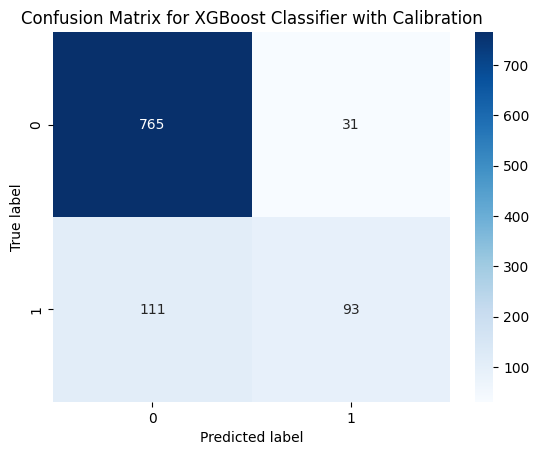

In [20]:
evaluate_model(y_test, y_test_pred, "XGBoost Classifier with Calibration")


In [22]:
# Path to save the model
save_path = "../models/xgboost_model.pkl"

# Save the model using pickle
with open(save_path, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved to {save_path}")

Model saved to ../models/xgboost_model.pkl


### 2. Model Explainer

In [23]:
# Convert all boolean columns to integers
X_train = X_train.astype({col: 'int64' for col in X_train.select_dtypes('bool').columns})
X_test = X_test.astype({col: 'int64' for col in X_test.select_dtypes('bool').columns})

In [24]:
# Create a SHAP explainer
explainer = shap.Explainer(best_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Visualize the summary plot
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('../models/xgboost_explanation.jpg', dpi=300, bbox_inches='tight')
plt.close()

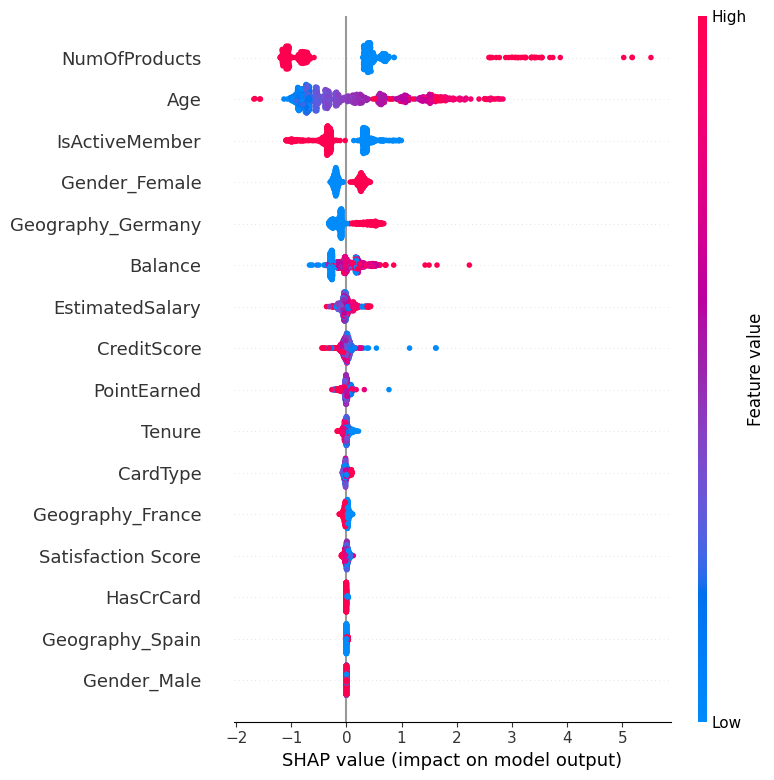

In [25]:
shap.summary_plot(shap_values, X_test, show=True)


The SHAP summary plot highlights key drivers of customer churn, where higher age, a greater number of products, and being an active member positively influence churn probability. Conversely, factors like higher balances, credit scores, and tenure reduce churn risk. Geography and gender-specific patterns indicate regional and demographic influences, with Germany and female customers contributing more to churn likelihood. These insights guide targeted retention strategies.